In [79]:
%run connect_twitter.ipynb

my API Connected !


In [80]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h3>Gathering Data</h3><br>
Find 200 most recent tweets fom user @realDonaldTrump:

In [112]:
name = '@realDonaldTrump'
nbr_tweets = 400
results = myapi.user_timeline(id=name, count=nbr_tweets)

In [113]:
data=[tweet.text for tweet in results]


Assemble the text into a dataframe

In [114]:
data = pd.DataFrame(data=[tweet.text for tweet in results],
                    columns=['Tweets'])

In [115]:
data.head()

,Tweets
0,"Just hit 50% in the Rasmussen Poll, much highe..."
1,"Slippery James Comey, a man who always ends up..."
2,Attorney Client privilege is now a thing of th...
3,I never asked Comey for Personal Loyalty. I ha...
4,"The Syrian raid was so perfectly carried out, ..."


The interesting part from here is the quantity of metadata contained in a single tweet. If we want to obtain data such as the creation date, or the source of creation, we can access the info with this attributes. An example is the following:

In [116]:
print(dir(results[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


Getting the meta data from the first tweet in the lsit

In [117]:
print('id:',results[0].id)
print('created at:',results[0].created_at)
print('source:',results[0].source)
print('likes:',results[0].favorite_count)
print('retweets:',results[0].retweet_count)
print('geo-location:',results[0].geo)
print('message:',results[0].text)

id: 985529299905187840
created at: 2018-04-15 14:44:30
source: Twitter for iPhone
likes: 109358
retweets: 23395
geo-location: None
message: Just hit 50% in the Rasmussen Poll, much higher than President Obama at same point. With all of the phony stories a… https://t.co/J2tMvPcCtK


<h4>Adding more data to the dataframe </h4>

In [118]:
data['len']  = np.array([len(tweet.text) for tweet in results])
data['ID']   = np.array([tweet.id for tweet in results])
data['Date'] = np.array([tweet.created_at for tweet in results])
data['Source'] = np.array([tweet.source for tweet in results])
data['Likes']  = np.array([tweet.favorite_count for tweet in results])
data['RTs']    = np.array([tweet.retweet_count for tweet in results])

In [119]:
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs
0,"Just hit 50% in the Rasmussen Poll, much highe...",140,985529299905187840,2018-04-15 14:44:30,Twitter for iPhone,109358,23395
1,"Slippery James Comey, a man who always ends up...",140,985504808646971392,2018-04-15 13:07:10,Twitter for iPhone,78612,18186
2,Attorney Client privilege is now a thing of th...,140,985502053345751040,2018-04-15 12:56:13,Twitter for iPhone,83876,20163
3,I never asked Comey for Personal Loyalty. I ha...,140,985496023555608576,2018-04-15 12:32:16,Twitter for iPhone,82106,18738
4,"The Syrian raid was so perfectly carried out, ...",140,985492862958698497,2018-04-15 12:19:42,Twitter for iPhone,94651,20509


<h3>Interpretation of the data</h3>

In [120]:
likes_max = np.max(data['Likes'])
retweet_max  = np.max(data['RTs'])

In [121]:
likes = data[data['Likes'] == likes_max].index[0]
retweets  = data[data.RTs == retweet_max].index[0]

In [122]:
retweets

148

In [123]:
# Max FAVs:
print("The tweet with most likes is: \n{}".format(data['Tweets'][likes]))
print("Number of likes: {}".format(likes_max))
print("{} characters.".format(data['len'][likes]))
print("Tweeted at {s}".format(s=data['Date'][likes]))

The tweet with most likes is: 
Crazy Joe Biden is trying to act like a tough guy. Actually, he is weak, both mentally and physically, and yet he t… https://t.co/4e33ZxnAw7
Number of likes: 257953
140 characters.
Tweeted at 2018-03-22 10:19:57


In [124]:
data.sort_values(by='Likes',ascending=False).head(4)

,Tweets,len,ID,Date,Source,Likes,RTs
148,Crazy Joe Biden is trying to act like a tough ...,140,976765417908776963,2018-03-22 10:19:57,Twitter for iPhone,257953,75550
104,HAPPY EASTER!,13,980421275326865409,2018-04-01 12:27:02,Twitter for iPhone,209538,41504
121,THE SECOND AMENDMENT WILL NEVER BE REPEALED! A...,140,978932860307505153,2018-03-28 09:52:36,Twitter for iPhone,194115,59183
11,A perfectly executed strike last night. Thank ...,140,985130802668294144,2018-04-14 12:21:00,Twitter for iPhone,191156,42658


<h3>Making Graphs</h3>

In [125]:
t_likes = pd.Series(data=data['Likes'].values, index=data['Date'])
type(t_likes)

pandas.core.series.Series

In [126]:
t_retweets = pd.Series(data=data['RTs'].values, index=data['Date'])

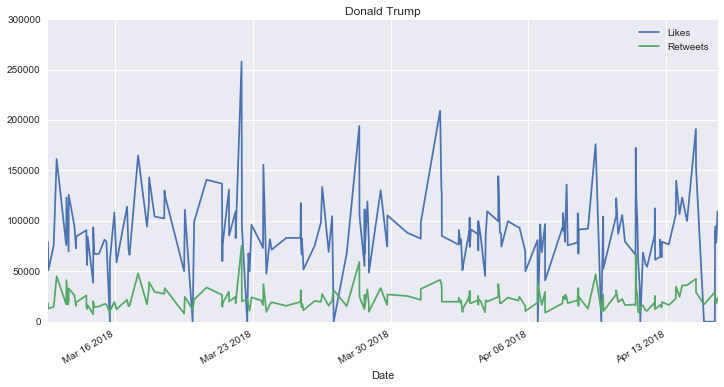

In [127]:
t_likes.plot(title='Donald Trump',
             figsize=(12,6),
             legend=True,
             label='Likes');
t_retweets.plot(legend=True,label='Retweets');

<h3>Sentiment Analysis of the Tweets</h3>

In [128]:
from textblob import TextBlob
import re

Define 2 different utility functions

In [129]:
def clean_tweet(tweet):
    '''
    Utility function to clean the text in a tweet by removing 
    links and special characters using regex.
    '''
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analyze_sentiment(tweet):
    '''
    Utility function to classify the polarity of a tweet
    using textblob.
    '''
    #analysis = TextBlob(clean_tweet(tweet))
    analysis = TextBlob(tweet)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [130]:
x  = [ analyze_sentiment(tweet) for tweet in data['Tweets'] ]

In [131]:
data['SA'] = np.array(x)

In [132]:
data.sort_values(by='Date',ascending=False,inplace=True)
data.head()

,Tweets,len,ID,Date,Source,Likes,RTs,SA
0,"Just hit 50% in the Rasmussen Poll, much highe...",140,985529299905187840,2018-04-15 14:44:30,Twitter for iPhone,109358,23395,1
1,"Slippery James Comey, a man who always ends up...",140,985504808646971392,2018-04-15 13:07:10,Twitter for iPhone,78612,18186,-1
2,Attorney Client privilege is now a thing of th...,140,985502053345751040,2018-04-15 12:56:13,Twitter for iPhone,83876,20163,1
3,I never asked Comey for Personal Loyalty. I ha...,140,985496023555608576,2018-04-15 12:32:16,Twitter for iPhone,82106,18738,-1
4,"The Syrian raid was so perfectly carried out, ...",140,985492862958698497,2018-04-15 12:19:42,Twitter for iPhone,94651,20509,1


The time has to be removed from the date

In [133]:
df.head()

,len,ID,Likes,RTs,SA,mood
Date,,,,,,
2018-03-12,418.0,2.919714e+18,206024.0,46461.0,3.0,NaN
2018-03-13,916.0,6.814853e+18,738824.0,199823.0,-1.0,NaN
2018-03-14,1156.0,9.739292e+18,729939.0,159888.0,6.0,NaN
2018-03-15,799.0,5.845765e+18,398208.0,88811.0,4.0,NaN
2018-03-16,487.0,3.898505e+18,311111.0,65172.0,3.0,15.0


In [134]:
data['Date']=data['Date'].apply(lambda x : pd.to_datetime(pd.to_datetime(x).strftime('%Y%m%d')))

In [135]:
df = data.groupby('Date').sum()

In [136]:
df.head()

,len,ID,Likes,RTs,SA
Date,,,,,
2018-03-12,418.0,2.919714e+18,206024.0,46461.0,3.0
2018-03-13,916.0,6.814853e+18,738824.0,199823.0,-1.0
2018-03-14,1156.0,9.739292e+18,729939.0,159888.0,6.0
2018-03-15,799.0,5.845765e+18,398208.0,88811.0,4.0
2018-03-16,487.0,3.898505e+18,311111.0,65172.0,3.0


In [137]:
df['mood']= df['SA'].rolling(window=5).apply(lambda x : np.sum(x))

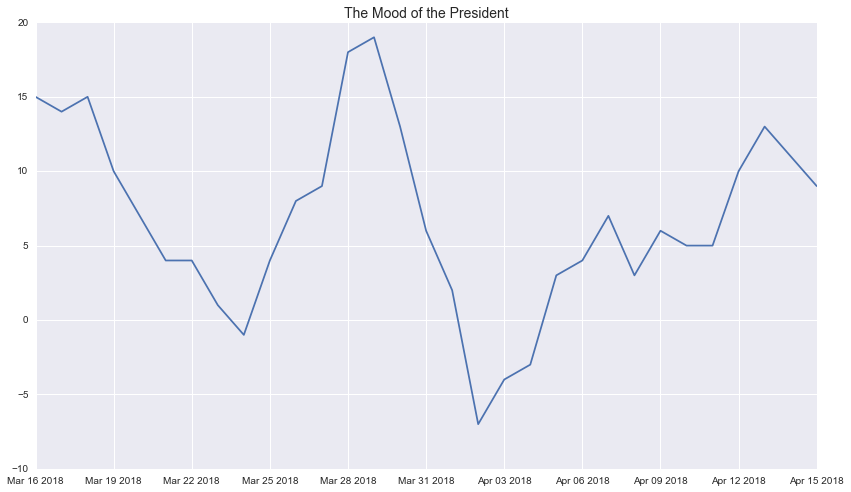

In [138]:
fig = plt.subplots(1,1,figsize=(14,8))
plt.plot(df.index,df['mood'])
plt.title('The Mood of the President',fontsize=14);

In [139]:
pos_tweets = [ tweet for index,tweet in enumerate(data['Tweets']) if data['SA'][index] > 0]
neu_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] == 0]
neg_tweets = [ tweet for index, tweet in enumerate(data['Tweets']) if data['SA'][index] < 0]

In [140]:
print(len(pos_tweets))
print(len(neu_tweets))
print(len(neg_tweets))

99
52
49


<h4>Most Liked positive tweet</h4>

In [141]:
df_positive = data[data['SA']>0].copy()
df_positive.sort_values(by='Likes',ascending=False,inplace=True)
df_positive.head()

,Tweets,len,ID,Date,Source,Likes,RTs,SA
104,HAPPY EASTER!,13,980421275326865409,2018-04-01,Twitter for iPhone,209538,41504,1
121,THE SECOND AMENDMENT WILL NEVER BE REPEALED! A...,140,978932860307505153,2018-03-28,Twitter for iPhone,194115,59183,1
11,A perfectly executed strike last night. Thank ...,140,985130802668294144,2018-04-14,Twitter for iPhone,191156,42658,1
35,Russia vows to shoot down any and all missiles...,140,984022625440747520,2018-04-11,Twitter for iPhone,172421,66938,1
169,"Andrew McCabe FIRED, a great day for the hard ...",140,974859881827258369,2018-03-17,Twitter for iPhone,164884,47925,1


In [145]:
df_positive.loc[169,['Tweets']]

Tweets    Andrew McCabe FIRED, a great day for the hard ...
Name: 169, dtype: object